In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 
currency = ["CHF","CAD","GBP","JPY","EUR","HKD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 45
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])


    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=5))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [8]:
"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2405 MiB, count=2, average=1202 MiB
[Training model......]
Train on 1112340 samples, validate on 342720 samples
Epoch 1/30
1112340/1112340 [==============================] - 11s 10us/step - loss: 0.7210 - acc: 0.5107 - val_loss: 0.6827 - val_acc: 0.5756
Epoch 2/30
1112340/1112340 [==============================] - 7s 7us/step - loss: 0.6806 - acc: 0.5553 - val_loss: 0.6672 - val_acc: 0.5968
Epoch 3/30
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6663 - acc: 0.5847 - val_loss: 0.6571 - val_acc: 0.6012
Epoch 4/30
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6572 - acc: 0.5981 - val_loss: 0.6509 - val_acc: 0.6018
Epoch 5/30
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6511 - acc: 0.6041 - val_loss: 0.6478 - val_acc: 0.6008
Epoch 6/30
1112340/1112340 

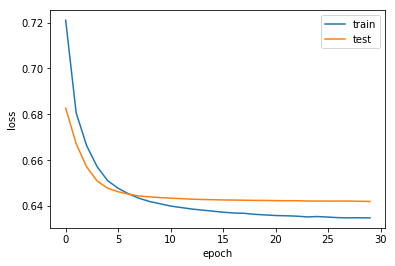

acc:
0.6157901360530916
val_acc:
0.6045168067004277


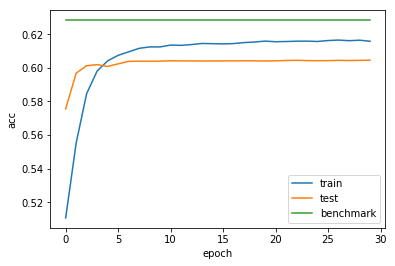

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2436 MiB, count=88, average=27.7 MiB
[Training model......]
Train on 1084260 samples, validate on 389580 samples
Epoch 1/30
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.7048 - acc: 0.5081 - val_loss: 0.6841 - val_acc: 0.5782
Epoch 2/30
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.6812 - acc: 0.5564 - val_loss: 0.6685 - val_acc: 0.5939
Epoch 3/30
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6673 - acc: 0.5845 - val_loss: 0.6565 - val_acc: 0.6034
Epoch 4/30
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6581 - acc: 0.5970 - val_loss: 0.6503 - val_acc: 0.6043
Epoch 5/30
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6531 - acc: 0.6025 - val_loss: 0.6474 - val_acc: 0.6049
Epoch 6/30
1084260/1084260 

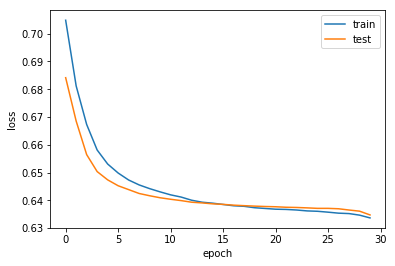

acc:
0.6139652851311187
val_acc:
0.6071564248564846


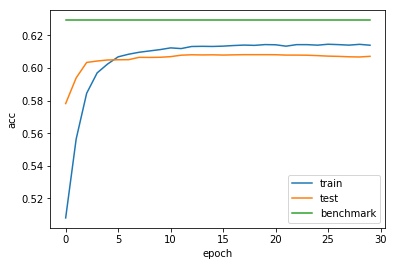

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2495 MiB, count=89, average=28.0 MiB
[Training model......]
Train on 1133640 samples, validate on 375840 samples
Epoch 1/30
1133640/1133640 [==============================] - 11s 10us/step - loss: 0.7224 - acc: 0.5142 - val_loss: 0.6808 - val_acc: 0.5789
Epoch 2/30
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.6818 - acc: 0.5539 - val_loss: 0.6695 - val_acc: 0.5909
Epoch 3/30
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.6677 - acc: 0.5838 - val_loss: 0.6564 - val_acc: 0.5984
Epoch 4/30
1133640/1133640 [==============================] - 7s 7us/step - loss: 0.6570 - acc: 0.6001 - val_loss: 0.6504 - val_acc: 0.6001
Epoch 5/30
1133640/1133640 [==============================] - 7s 7us/step - loss: 0.6518 - acc: 0.6061 - val_loss: 0.6481 - val_acc: 0.6008
Epoch 6/30
1133640/1133640

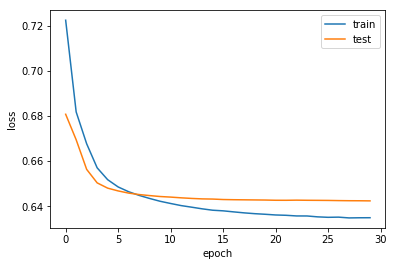

acc:
0.6150973854953806
val_acc:
0.6005188379352678


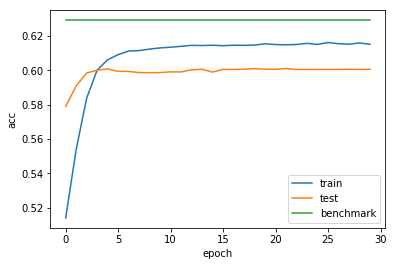

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2438 MiB, count=90, average=27.1 MiB
[Training model......]
Train on 1116780 samples, validate on 358560 samples
Epoch 1/30
1116780/1116780 [==============================] - 11s 10us/step - loss: 0.7111 - acc: 0.5110 - val_loss: 0.6878 - val_acc: 0.5640
Epoch 2/30
1116780/1116780 [==============================] - 8s 7us/step - loss: 0.6871 - acc: 0.5442 - val_loss: 0.6777 - val_acc: 0.5894
Epoch 3/30
1116780/1116780 [==============================] - 8s 7us/step - loss: 0.6750 - acc: 0.5720 - val_loss: 0.6648 - val_acc: 0.5986
Epoch 4/30
1116780/1116780 [==============================] - 7s 7us/step - loss: 0.6625 - acc: 0.5930 - val_loss: 0.6548 - val_acc: 0.5967
Epoch 5/30
1116780/1116780 [==============================] - 7s 6us/step - loss: 0.6548 - acc: 0.6015 - val_loss: 0.6508 - val_acc: 0.6023
Epoch 6/30
1116780/1116780

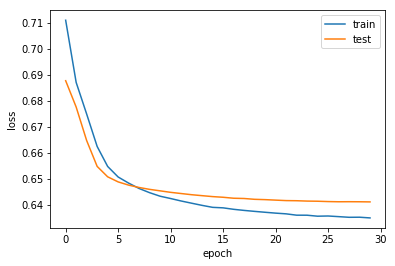

acc:
0.615806157030817
val_acc:
0.6046352075658064


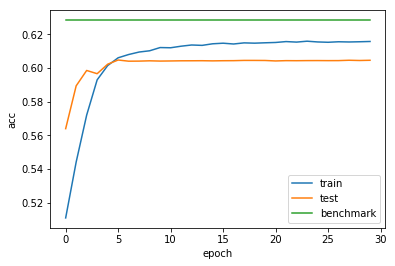

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=91, average=27.7 MiB
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/30
1132620/1132620 [==============================] - 11s 10us/step - loss: 0.7737 - acc: 0.5060 - val_loss: 0.6836 - val_acc: 0.5569
Epoch 2/30
1132620/1132620 [==============================] - 8s 7us/step - loss: 0.6919 - acc: 0.5307 - val_loss: 0.6742 - val_acc: 0.5873
Epoch 3/30
1132620/1132620 [==============================] - 7s 7us/step - loss: 0.6740 - acc: 0.5638 - val_loss: 0.6630 - val_acc: 0.5925
Epoch 4/30
1132620/1132620 [==============================] - 8s 7us/step - loss: 0.6616 - acc: 0.5867 - val_loss: 0.6562 - val_acc: 0.5912
Epoch 5/30
1132620/1132620 [==============================] - 7s 7us/step - loss: 0.6550 - acc: 0.5982 - val_loss: 0.6527 - val_acc: 0.5948
Epoch 6/30
1132620/1132620

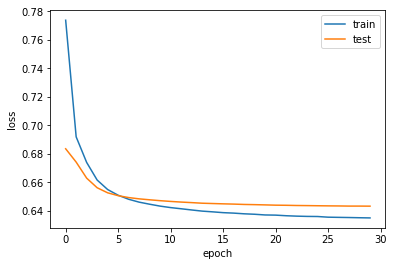

acc:
0.6157378467499544
val_acc:
0.6008445257280821


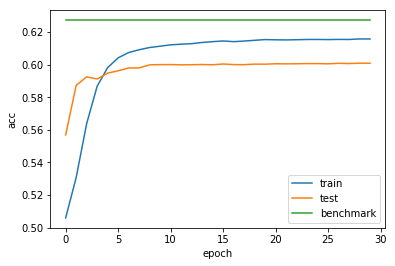

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

In [10]:
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 36, 6)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 32, 20)       620         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 20)       2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 20)       2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

train_acc:red,test_acc:blue


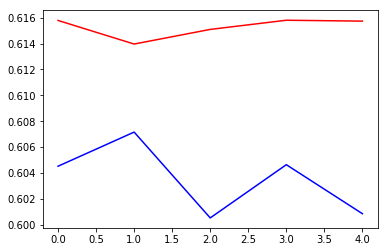

train_loss:red,test_loss:blue


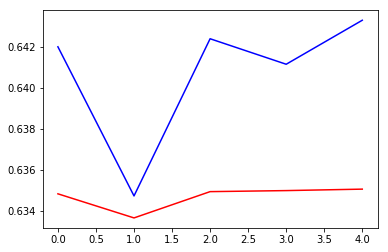

trend:red,vol:blue


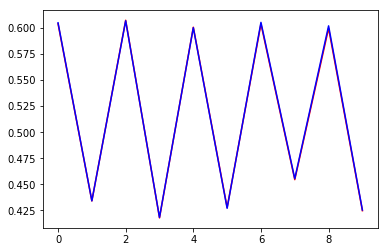

In [11]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [12]:
K.clear_session()

In [8]:
"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)

    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    


In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 9
tail = 21
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2429 MiB, count=2, average=1215 MiB
[Training model......]
Train on 1099080 samples, validate on 370800 samples
Epoch 1/45
1099080/1099080 [==============================] - 11s 10us/step - loss: 0.7046 - acc: 0.5152 - val_loss: 0.6786 - val_acc: 0.5630
Epoch 2/45
1099080/1099080 [==============================] - 8s 7us/step - loss: 0.6788 - acc: 0.5524 - val_loss: 0.6578 - val_acc: 0.6039
Epoch 3/45
1099080/1099080 [==============================] - 7s 7us/step - loss: 0.6633 - acc: 0.5859 - val_loss: 0.6444 - val_acc: 0.6099
Epoch 4/45
1099080/1099080 [==============================] - 8s 7us/step - loss: 0.6554 - acc: 0.5989 - val_loss: 0.6399 - val_acc: 0.6104
Epoch 5/45
1099080/1099080 [==============================] - 8s 7us/step - loss: 0.6515 - acc: 0.6025 - val_loss: 0.6378 - val_acc: 0.6124
Epoch 6/45
1099080/1099080 [

1120920/1120920 [==============================] - 8s 7us/step - loss: 0.6499 - acc: 0.6044 - val_loss: 0.6395 - val_acc: 0.6126
Epoch 8/45
1120920/1120920 [==============================] - 7s 7us/step - loss: 0.6477 - acc: 0.6063 - val_loss: 0.6389 - val_acc: 0.6125
Epoch 9/45
1120920/1120920 [==============================] - 7s 7us/step - loss: 0.6465 - acc: 0.6070 - val_loss: 0.6382 - val_acc: 0.6125
Epoch 10/45
1120920/1120920 [==============================] - 8s 7us/step - loss: 0.6455 - acc: 0.6067 - val_loss: 0.6376 - val_acc: 0.6127
Epoch 11/45
1120920/1120920 [==============================] - 8s 7us/step - loss: 0.6446 - acc: 0.6071 - val_loss: 0.6372 - val_acc: 0.6128
Epoch 12/45
1120920/1120920 [==============================] - 7s 7us/step - loss: 0.6439 - acc: 0.6079 - val_loss: 0.6368 - val_acc: 0.6128
Epoch 13/45
1120920/1120920 [==============================] - 7s 7us/step - loss: 0.6433 - acc: 0.6084 - val_loss: 0.6366 - val_acc: 0.6128
Epoch 14/45
1120920/1120920

1095240/1095240 [==============================] - 7s 7us/step - loss: 0.6435 - acc: 0.6082 - val_loss: 0.6336 - val_acc: 0.6110
Epoch 16/45
1095240/1095240 [==============================] - 7s 7us/step - loss: 0.6430 - acc: 0.6086 - val_loss: 0.6333 - val_acc: 0.6111
Epoch 17/45
1095240/1095240 [==============================] - 7s 7us/step - loss: 0.6429 - acc: 0.6082 - val_loss: 0.6332 - val_acc: 0.6128
Epoch 18/45
1095240/1095240 [==============================] - 7s 7us/step - loss: 0.6422 - acc: 0.6087 - val_loss: 0.6330 - val_acc: 0.6100
Epoch 19/45
1095240/1095240 [==============================] - 8s 7us/step - loss: 0.6424 - acc: 0.6089 - val_loss: 0.6331 - val_acc: 0.6100
Epoch 20/45
1095240/1095240 [==============================] - 7s 6us/step - loss: 0.6419 - acc: 0.6089 - val_loss: 0.6329 - val_acc: 0.6116
Epoch 21/45
1095240/1095240 [==============================] - 7s 6us/step - loss: 0.6417 - acc: 0.6090 - val_loss: 0.6329 - val_acc: 0.6116
Epoch 22/45
1095240/10952

1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6420 - acc: 0.6088 - val_loss: 0.6363 - val_acc: 0.6136
Epoch 24/45
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6420 - acc: 0.6089 - val_loss: 0.6364 - val_acc: 0.6120
Epoch 25/45
1112340/1112340 [==============================] - 7s 7us/step - loss: 0.6417 - acc: 0.6086 - val_loss: 0.6361 - val_acc: 0.6123
Epoch 26/45
1112340/1112340 [==============================] - 8s 7us/step - loss: 0.6416 - acc: 0.6084 - val_loss: 0.6360 - val_acc: 0.6117
Epoch 27/45
1112340/1112340 [==============================] - 8s 7us/step - loss: 0.6413 - acc: 0.6085 - val_loss: 0.6359 - val_acc: 0.6132
Epoch 28/45
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6412 - acc: 0.6087 - val_loss: 0.6358 - val_acc: 0.6136
Epoch 29/45
1112340/1112340 [==============================] - 7s 6us/step - loss: 0.6410 - acc: 0.6089 - val_loss: 0.6356 - val_acc: 0.6136
Epoch 30/45
1112340/11123

1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6397 - acc: 0.6100 - val_loss: 0.6340 - val_acc: 0.6091
Epoch 32/45
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.6397 - acc: 0.6100 - val_loss: 0.6340 - val_acc: 0.6091
Epoch 33/45
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6395 - acc: 0.6106 - val_loss: 0.6339 - val_acc: 0.6088
Epoch 34/45
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.6395 - acc: 0.6099 - val_loss: 0.6340 - val_acc: 0.6089
Epoch 35/45
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6393 - acc: 0.6108 - val_loss: 0.6339 - val_acc: 0.6090
Epoch 36/45
1084260/1084260 [==============================] - 7s 7us/step - loss: 0.6389 - acc: 0.6112 - val_loss: 0.6337 - val_acc: 0.6087
Epoch 37/45
1084260/1084260 [==============================] - 7s 6us/step - loss: 0.6389 - acc: 0.6107 - val_loss: 0.6337 - val_acc: 0.6087
Epoch 38/45
1084260/10842

1133640/1133640 [==============================] - 7s 6us/step - loss: 0.6389 - acc: 0.6101 - val_loss: 0.6321 - val_acc: 0.6140
Epoch 40/45
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.6388 - acc: 0.6105 - val_loss: 0.6321 - val_acc: 0.6152
Epoch 41/45
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.6387 - acc: 0.6099 - val_loss: 0.6319 - val_acc: 0.6151
Epoch 42/45
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.6386 - acc: 0.6102 - val_loss: 0.6319 - val_acc: 0.6152
Epoch 43/45
1133640/1133640 [==============================] - 7s 6us/step - loss: 0.6385 - acc: 0.6104 - val_loss: 0.6320 - val_acc: 0.6153
Epoch 44/45
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.6385 - acc: 0.6098 - val_loss: 0.6318 - val_acc: 0.6149
Epoch 45/45
1133640/1133640 [==============================] - 8s 7us/step - loss: 0.6386 - acc: 0.6101 - val_loss: 0.6320 - val_acc: 0.6150
[[0.49915755]
 [0.4996921

[[0.52753156]
 [0.4493295 ]
 [0.46389183]
 ...
 [0.49801096]
 [0.27516153]
 [0.27516153]]
猜答案多的那邊 benchacc1:
0.5
參考前一個答案 benchacc2:
0.6132446452476573
(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=92, average=27.4 MiB
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/45
1132620/1132620 [==============================] - 12s 11us/step - loss: 0.7232 - acc: 0.5138 - val_loss: 0.6793 - val_acc: 0.5903
Epoch 2/45
1132620/1132620 [==============================] - 8s 7us/step - loss: 0.6836 - acc: 0.5456 - val_loss: 0.6664 - val_acc: 0.6149
Epoch 3/45
1132620/1132620 [==============================] - 8s 7us/step - loss: 0.6731 - acc: 0.5684 - val_loss: 0.6554 - val_acc: 0.6172
Epoch 4/45
1132620/1132620 [==============================] - 7s 7us/step - loss: 0.6652 - acc: 0.5821 - val_loss: 0.6476 - val_acc: 0.6174
Epoch 5/45
1132

1136160/1136160 [==============================] - 7s 6us/step - loss: 0.6562 - acc: 0.5972 - val_loss: 0.6423 - val_acc: 0.6170
Epoch 7/45
1136160/1136160 [==============================] - 7s 6us/step - loss: 0.6540 - acc: 0.6005 - val_loss: 0.6414 - val_acc: 0.6171
Epoch 8/45
1136160/1136160 [==============================] - 8s 7us/step - loss: 0.6520 - acc: 0.6032 - val_loss: 0.6400 - val_acc: 0.6174
Epoch 9/45
1136160/1136160 [==============================] - 8s 7us/step - loss: 0.6505 - acc: 0.6053 - val_loss: 0.6387 - val_acc: 0.6173
Epoch 10/45
1136160/1136160 [==============================] - 7s 6us/step - loss: 0.6493 - acc: 0.6064 - val_loss: 0.6383 - val_acc: 0.6127
Epoch 11/45
1136160/1136160 [==============================] - 8s 7us/step - loss: 0.6485 - acc: 0.6065 - val_loss: 0.6375 - val_acc: 0.6127
Epoch 12/45
1136160/1136160 [==============================] - 8s 7us/step - loss: 0.6477 - acc: 0.6078 - val_loss: 0.6369 - val_acc: 0.6127
Epoch 13/45
1136160/1136160 

1122420/1122420 [==============================] - 7s 7us/step - loss: 0.6452 - acc: 0.6082 - val_loss: 0.6359 - val_acc: 0.6107
Epoch 15/45
1122420/1122420 [==============================] - 8s 7us/step - loss: 0.6448 - acc: 0.6077 - val_loss: 0.6354 - val_acc: 0.6102
Epoch 16/45
1122420/1122420 [==============================] - 8s 7us/step - loss: 0.6439 - acc: 0.6077 - val_loss: 0.6355 - val_acc: 0.6105
Epoch 17/45
1122420/1122420 [==============================] - 7s 7us/step - loss: 0.6436 - acc: 0.6079 - val_loss: 0.6352 - val_acc: 0.6104
Epoch 18/45
1122420/1122420 [==============================] - 7s 6us/step - loss: 0.6432 - acc: 0.6083 - val_loss: 0.6353 - val_acc: 0.6096
Epoch 19/45
1122420/1122420 [==============================] - 7s 6us/step - loss: 0.6428 - acc: 0.6076 - val_loss: 0.6350 - val_acc: 0.6102
Epoch 20/45
1122420/1122420 [==============================] - 7s 7us/step - loss: 0.6425 - acc: 0.6080 - val_loss: 0.6348 - val_acc: 0.6121
Epoch 21/45
1122420/11224

1136100/1136100 [==============================] - 8s 7us/step - loss: 0.6407 - acc: 0.6092 - val_loss: 0.6308 - val_acc: 0.6157
Epoch 23/45
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.6406 - acc: 0.6085 - val_loss: 0.6309 - val_acc: 0.6156
Epoch 24/45
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.6403 - acc: 0.6095 - val_loss: 0.6309 - val_acc: 0.6157
Epoch 25/45
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.6403 - acc: 0.6090 - val_loss: 0.6309 - val_acc: 0.6157
Epoch 26/45
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.6402 - acc: 0.6090 - val_loss: 0.6308 - val_acc: 0.6157
Epoch 27/45
1136100/1136100 [==============================] - 8s 7us/step - loss: 0.6399 - acc: 0.6093 - val_loss: 0.6310 - val_acc: 0.6158
Epoch 28/45
1136100/1136100 [==============================] - 7s 6us/step - loss: 0.6401 - acc: 0.6085 - val_loss: 0.6309 - val_acc: 0.6157
Epoch 29/45
1136100/11361

1117740/1117740 [==============================] - 8s 7us/step - loss: 0.6399 - acc: 0.6082 - val_loss: 0.6321 - val_acc: 0.6110
Epoch 31/45
1117740/1117740 [==============================] - 7s 7us/step - loss: 0.6397 - acc: 0.6091 - val_loss: 0.6320 - val_acc: 0.6110
Epoch 32/45
1117740/1117740 [==============================] - 7s 7us/step - loss: 0.6396 - acc: 0.6085 - val_loss: 0.6321 - val_acc: 0.6110
Epoch 33/45
1117740/1117740 [==============================] - 7s 7us/step - loss: 0.6396 - acc: 0.6088 - val_loss: 0.6320 - val_acc: 0.6129
Epoch 34/45
1117740/1117740 [==============================] - 7s 7us/step - loss: 0.6395 - acc: 0.6085 - val_loss: 0.6320 - val_acc: 0.6109
Epoch 35/45
1117740/1117740 [==============================] - 7s 7us/step - loss: 0.6394 - acc: 0.6089 - val_loss: 0.6320 - val_acc: 0.6110
Epoch 36/45
1117740/1117740 [==============================] - 8s 7us/step - loss: 0.6391 - acc: 0.6093 - val_loss: 0.6322 - val_acc: 0.6110
Epoch 37/45
1117740/11177